In [1]:
%cd ..

import torch
from torch.utils.data import DataLoader, TensorDataset

from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.measurements.default import default_measurement
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit
from src.nn.encodings.IQP_embedding import custom_iqp_embedding
from src.nn.encodings.NQE_embedding import NQE_embedding
from src.nn.encodings.ring_embedding import ring_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding, QAOA_embedding
from src.utils.dataset import EuroSAT
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer

import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

c:\Users\jesus.lozano\Desktop\Demostrador1\Paper\Repositorio\QML-Satellite-Image-Classification-main


C:\Users\jesus.lozano\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
print(os.getcwd())

c:\Users\jesus.lozano\Desktop\Demostrador1\Paper\Repositorio\QML-Satellite-Image-Classification-main


In [3]:
limit = 100

allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

config = {
    #'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
    #'allowed_classes': ['HerbaceousVegetation', 'Highway', 'Pasture', 'River', 'SeaLake']
    #'allowed_classes': ['Highway', 'River', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
n_classes = 10 if allowed_classes is None else len(allowed_classes)


output = 'dl'
dataset = EuroSAT(num_classes=n_classes,
                        image_size=8,
                        examples_per_class=limit,
                        batch_size=4,
                        allowed_classes=allowed_classes,
                        output = output
                 )

if output == 'dl':
    train_loader, val_loader = dataset.get_loaders()
else:
    X_train, y_train, X_val, y_val, index_mapping = dataset.get_loaders()

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train) 
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True


Class distribution in train set:
Class 0: 80
Class 1: 80
Class 2: 80
Class 3: 80
Class 4: 80
Class 5: 80
Class 6: 80
Class 7: 80
Class 8: 80
Class 9: 80

Class distribution in validation set:
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
Class 5: 20
Class 6: 20
Class 7: 20
Class 8: 20
Class 9: 20


## Choose params - FlexHybridCNN

In [4]:
embedding_type = "ring"
circuit = no_entanglement_random_circuit
measurement = default_measurement

use_quantum = True # Quanvolution or classic model
log_wandb = False #graph accuracies in wandb
plot = True #plot confusion matrix

learning_rate = 0.01
epochs = 10

In [5]:
if embedding_type == "angle":
    # Angle embedding
    embedding = angle_embedding
    params = {}
    name_prueba = [f"Pruebas Angle embedding limit = {limit}"]

elif embedding_type == "amplitude":
    # Amplitude embedding
    embedding = amplitude_embedding
    params = {}
    name_prueba = [f"Pruebas Amplitude embedding limit = {limit}"]

elif embedding_type == "IQP":
    # IQP embedding
    embedding = custom_iqp_embedding
    params = {"embedding": {"n_repeats": 2}}
    name_prueba = [f"Pruebas IQP embedding limit = {limit}"]

elif embedding_type == "NQE":
    # NQE embedding
    embedding = NQE_embedding
    params = {"embedding": {"n_repeats": 2}}
    name_prueba = [f"Pruebas NQE embedding limit = {limit}"]

elif embedding_type == "QAOA":
    # Squeezing embedding
    embedding = QAOA_embedding
    params = {"embedding":{"qkernel_shape": 2}}
    name_prueba = [f"Pruebas QAOA embedding limit = {limit}"]

elif embedding_type == "ring":
    # Ring embedding
    embedding = ring_embedding
    params = {"embedding":{"n_repeats": 1}}
    name_prueba = [f"Pruebas Ring embedding limit = {limit}"]

elif embedding_type == "waterfall":
    # Ring embedding
    embedding = waterfall_embedding
    params = {"embedding":{"n_repeats": 1}}
    name_prueba = [f"Pruebas Waterfall embedding limit = {limit}"]

if use_quantum:
    prename = "quantum_eurosat_"
    name_run = [circuit.__name__]
    name_prueba = [f"Pruebas quantum limit = {limit}"]
    quanv_params = {
    "embedding": embedding,
    "circuit": circuit,
    "measurement": measurement,
    "params": params,
    }
    
else:
    prename = "classic_eurosat_"
    name_run = ["classic"]
    name_prueba = [f"Pruebas classic limit = {limit}"]
    quanv_params = None


model = FlexHybridCNN(n_classes = len(allowed_classes), 
                      use_quantum = use_quantum, 
                      qkernel_shape = 3, 
                      kernel_size_2 = 7,
                      quanv_params = quanv_params,
                     )
    
experiment_name = prename + embedding_type + "_" + circuit.__name__ + "_" + str(limit) + ","

In [6]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  log_wandb = log_wandb,
                  wandb_project = name_prueba,
                  wandb_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate
                 )

Epoch [1/10]: Train Loss = 2.0720, Train Acc = 26.1250%, Val Loss = 2.2081, Val Acc = 31.0000%
Epoch [2/10]: Train Loss = 1.9185, Train Acc = 32.0000%, Val Loss = 1.9800, Val Acc = 30.5000%
Epoch [3/10]: Train Loss = 1.6102, Train Acc = 40.6250%, Val Loss = 2.1364, Val Acc = 29.0000%
Epoch [4/10]: Train Loss = 1.4925, Train Acc = 46.8750%, Val Loss = 1.7674, Val Acc = 40.5000%
Epoch [5/10]: Train Loss = 1.3216, Train Acc = 53.2500%, Val Loss = 2.2288, Val Acc = 38.5000%
Epoch [6/10]: Train Loss = 1.2931, Train Acc = 55.2500%, Val Loss = 1.8306, Val Acc = 43.0000%
Epoch [7/10]: Train Loss = 1.1221, Train Acc = 61.6250%, Val Loss = 2.0519, Val Acc = 45.5000%
Epoch [8/10]: Train Loss = 1.0536, Train Acc = 64.3750%, Val Loss = 2.0795, Val Acc = 46.0000%
Epoch [9/10]: Train Loss = 1.0114, Train Acc = 66.0000%, Val Loss = 2.5735, Val Acc = 40.5000%
Epoch [10/10]: Train Loss = 1.1280, Train Acc = 63.5000%, Val Loss = 2.4117, Val Acc = 45.5000%


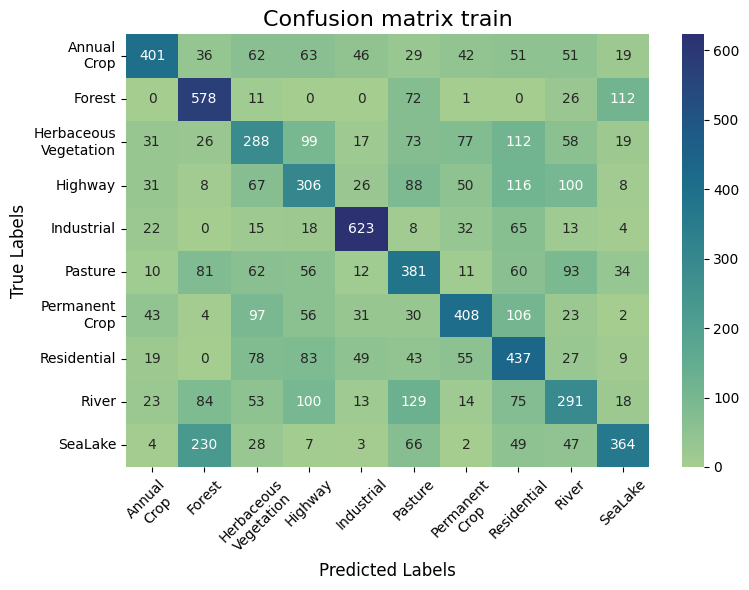

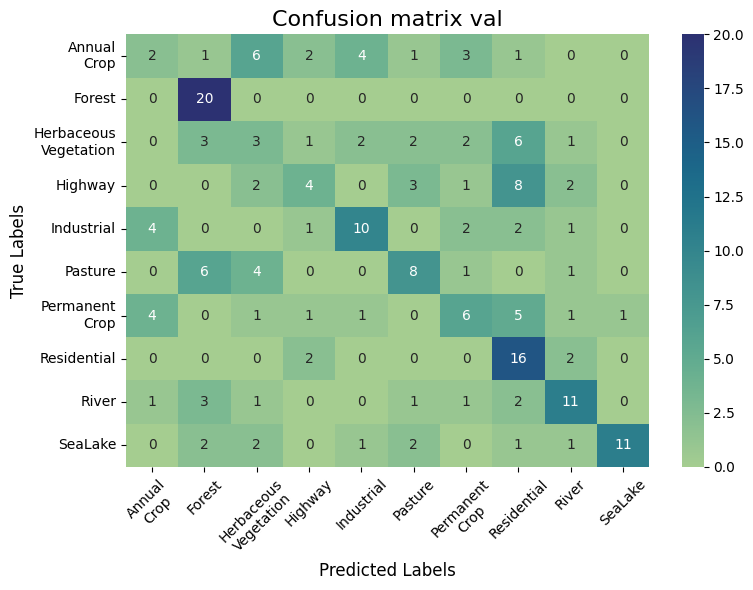

In [7]:
trainer.fit()

## Choose params - HQNN Parallel